<a href="https://colab.research.google.com/github/DGuilherme/PMTese/blob/main/Turbofan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [28]:
#import

# Install any missing libraries
!pip install tensorflow

# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam


# Data load

In [40]:
from google.colab import drive
drive.mount('/content/drive')

column_names = ['id', 'cycle', 'setting1', 'setting2', 'setting3'] + [f'sensor{i}' for i in range(1, 22)]


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Load FD001


In [71]:
# Load the dataset
# /content/drive/MyDrive/Python/predictive-maintenance-main/datasets/cmapss/train_FD001.txt
train_data = pd.read_csv('/content/drive/MyDrive/Python/predictive-maintenance-main/datasets/cmapss/train_FD001.txt/train_FD001.txt', delim_whitespace=True, header=None)
test_data = pd.read_csv('/content/drive/MyDrive/Python/predictive-maintenance-main/datasets/cmapss/test_FD001.txt/test_FD001.txt', delim_whitespace=True, header=None)
rul_data = pd.read_csv('/content/drive/MyDrive/Python/predictive-maintenance-main/datasets/cmapss/RUL_FD001.txt/RUL_FD001.txt', delim_whitespace=True, header=None)


# Basic Data Info

In [72]:
train_data.columns = column_names
test_data.columns = column_names
rul_data.columns = ['RUL']

print('---------------------Train Data---------------------')
print(train_data.head())
print('---------------------Test Data----------------------')
print(test_data.head())
print('----------------------RUL Data----------------------')
print(rul_data.head())

---------------------Train Data---------------------
   id  cycle  setting1  setting2  setting3  sensor1  sensor2  sensor3  \
0   1      1   -0.0007   -0.0004     100.0   518.67   641.82  1589.70   
1   1      2    0.0019   -0.0003     100.0   518.67   642.15  1591.82   
2   1      3   -0.0043    0.0003     100.0   518.67   642.35  1587.99   
3   1      4    0.0007    0.0000     100.0   518.67   642.35  1582.79   
4   1      5   -0.0019   -0.0002     100.0   518.67   642.37  1582.85   

   sensor4  sensor5  ...  sensor12  sensor13  sensor14  sensor15  sensor16  \
0  1400.60    14.62  ...    521.66   2388.02   8138.62    8.4195      0.03   
1  1403.14    14.62  ...    522.28   2388.07   8131.49    8.4318      0.03   
2  1404.20    14.62  ...    522.42   2388.03   8133.23    8.4178      0.03   
3  1401.87    14.62  ...    522.86   2388.08   8133.83    8.3682      0.03   
4  1406.22    14.62  ...    522.19   2388.04   8133.80    8.4294      0.03   

   sensor17  sensor18  sensor19  sensor

In [44]:
# Check the shape of the data
print(f"Training Data Shape: {train_data.shape}")
print(f"Test Data Shape: {test_data.shape}")
print(f"RUL Data Shape: {rul_data.shape}")

# Check for missing values
print('---------------------Train Data---------------------')
print(train_data.isnull().sum())
print('---------------------Test Data----------------------')
print(test_data.isnull().sum())
print('----------------------RUL Data----------------------')
print(rul_data.isnull().sum())

Training Data Shape: (20631, 26)
Test Data Shape: (13096, 26)
RUL Data Shape: (100, 1)
---------------------Train Data---------------------
id          0
cycle       0
setting1    0
setting2    0
setting3    0
sensor1     0
sensor2     0
sensor3     0
sensor4     0
sensor5     0
sensor6     0
sensor7     0
sensor8     0
sensor9     0
sensor10    0
sensor11    0
sensor12    0
sensor13    0
sensor14    0
sensor15    0
sensor16    0
sensor17    0
sensor18    0
sensor19    0
sensor20    0
sensor21    0
dtype: int64
---------------------Test Data----------------------
id          0
cycle       0
setting1    0
setting2    0
setting3    0
sensor1     0
sensor2     0
sensor3     0
sensor4     0
sensor5     0
sensor6     0
sensor7     0
sensor8     0
sensor9     0
sensor10    0
sensor11    0
sensor12    0
sensor13    0
sensor14    0
sensor15    0
sensor16    0
sensor17    0
sensor18    0
sensor19    0
sensor20    0
sensor21    0
dtype: int64
----------------------RUL Data----------------------


In [45]:
print(train_data.describe())


                 id         cycle      setting1      setting2  setting3  \
count  20631.000000  20631.000000  20631.000000  20631.000000   20631.0   
mean      51.506568    108.807862     -0.000009      0.000002     100.0   
std       29.227633     68.880990      0.002187      0.000293       0.0   
min        1.000000      1.000000     -0.008700     -0.000600     100.0   
25%       26.000000     52.000000     -0.001500     -0.000200     100.0   
50%       52.000000    104.000000      0.000000      0.000000     100.0   
75%       77.000000    156.000000      0.001500      0.000300     100.0   
max      100.000000    362.000000      0.008700      0.000600     100.0   

        sensor1       sensor2       sensor3       sensor4       sensor5  ...  \
count  20631.00  20631.000000  20631.000000  20631.000000  2.063100e+04  ...   
mean     518.67    642.680934   1590.523119   1408.933782  1.462000e+01  ...   
std        0.00      0.500053      6.131150      9.000605  1.776400e-15  ...   
min 

# Data Visualization

## Cycle Distribution
Quantos motores atingiram determinado numero de ciclos.


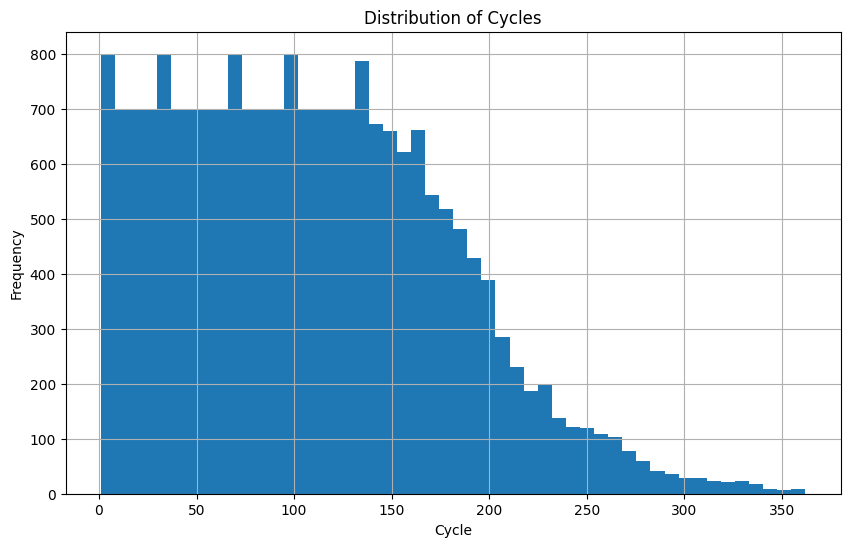

In [10]:
plt.figure(figsize=(10, 6))
train_data['cycle'].hist(bins=50)
plt.xlabel('Cycle')
plt.ylabel('Frequency')
plt.title('Distribution of Cycles')
plt.show()


## Sensor info

Sensores 1,5,6,10,16,18,19 talvez nao sejam importantes.


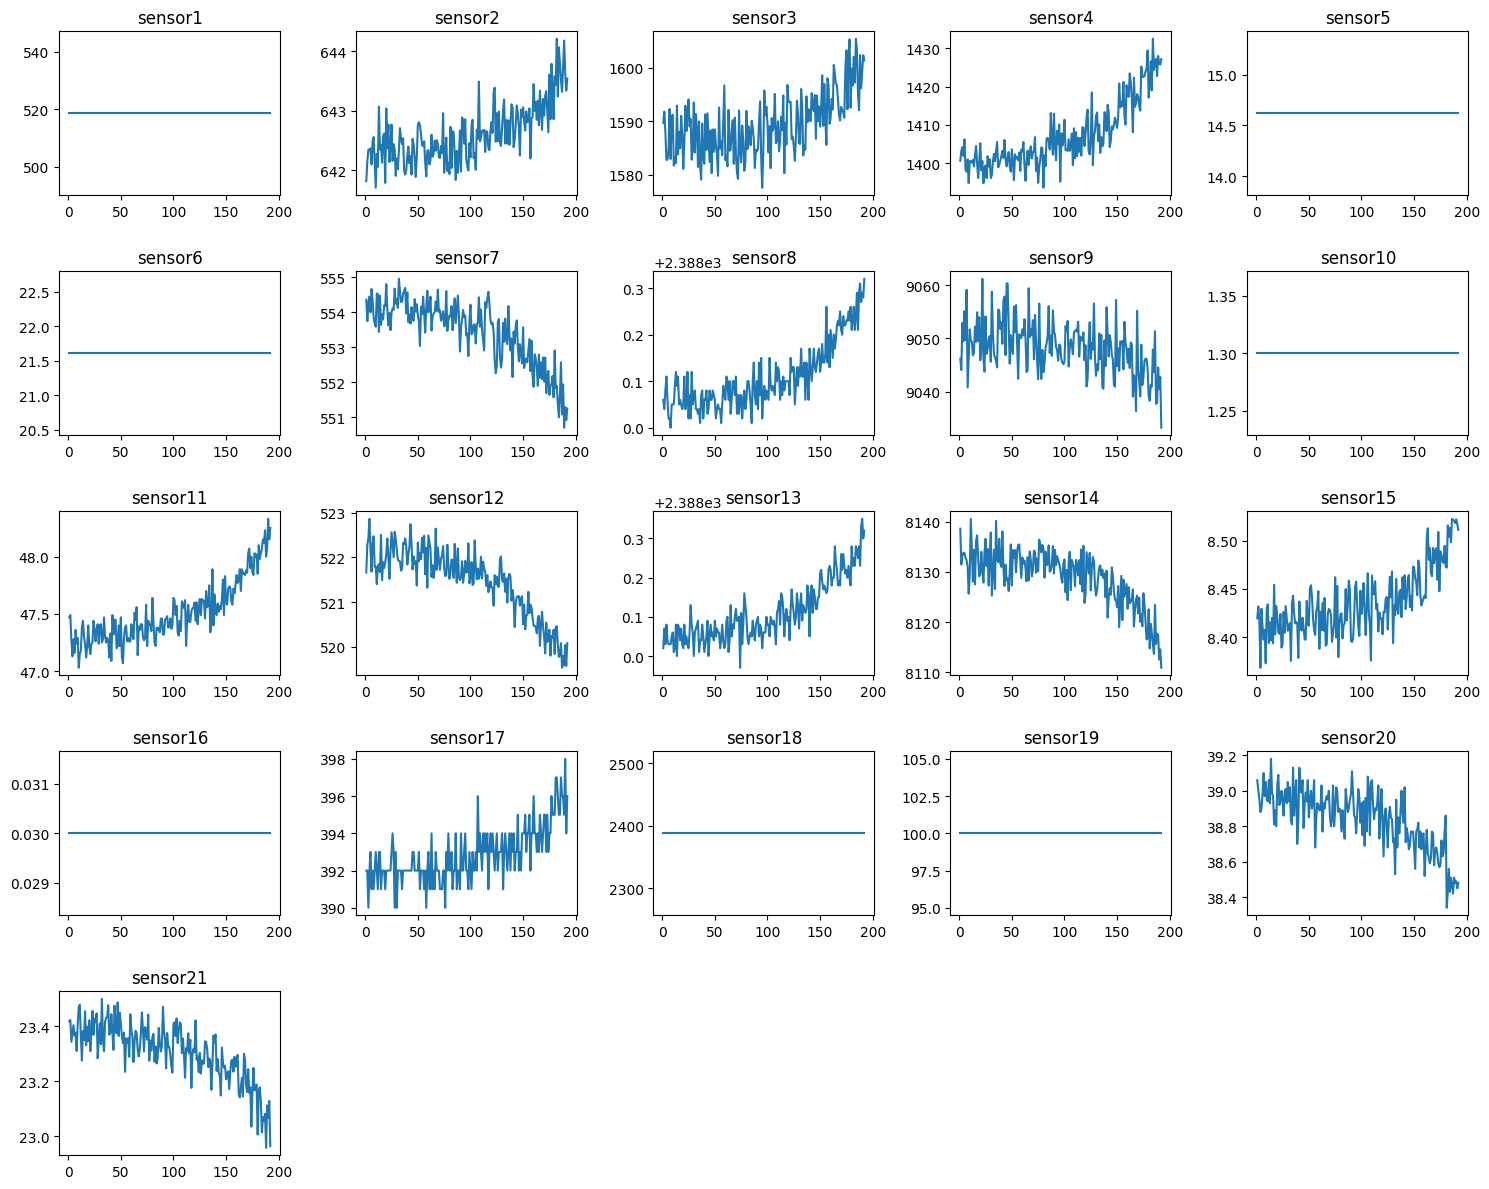

In [ ]:
engine_id = 1
engine_data = train_data[train_data['id'] == engine_id]

plt.figure(figsize=(15, 12))
for i in range(5, train_data.shape[1]):
    plt.subplot(5, 5, i-4)
    plt.plot(engine_data['cycle'], engine_data.iloc[:, i])
    plt.title(train_data.columns[i])
plt.tight_layout()
plt.show()


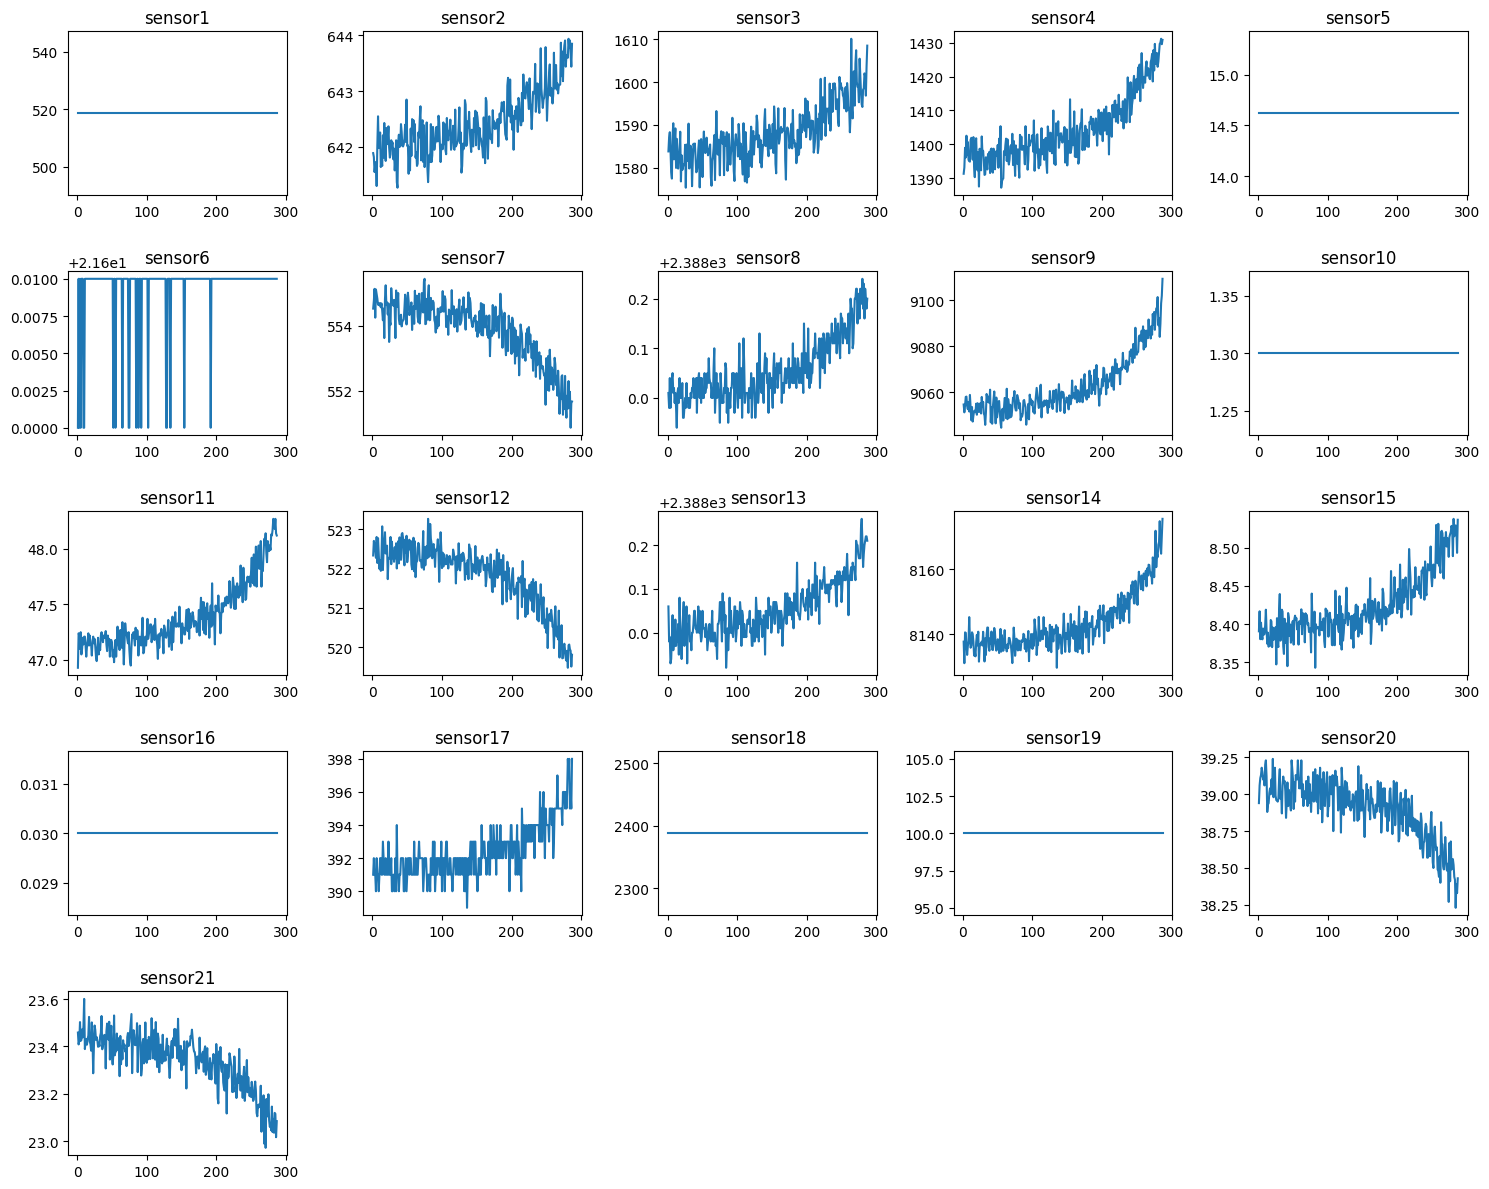

In [ ]:
engine_id = 2
engine_data = train_data[train_data['id'] == engine_id]

plt.figure(figsize=(15, 12))
for i in range(5, train_data.shape[1]):
    plt.subplot(5, 5, i-4)
    plt.plot(engine_data['cycle'], engine_data.iloc[:, i])
    plt.title(train_data.columns[i])
plt.tight_layout()
plt.show()

## Operational Settings
Ao longo do tempo as settings sao constantes.

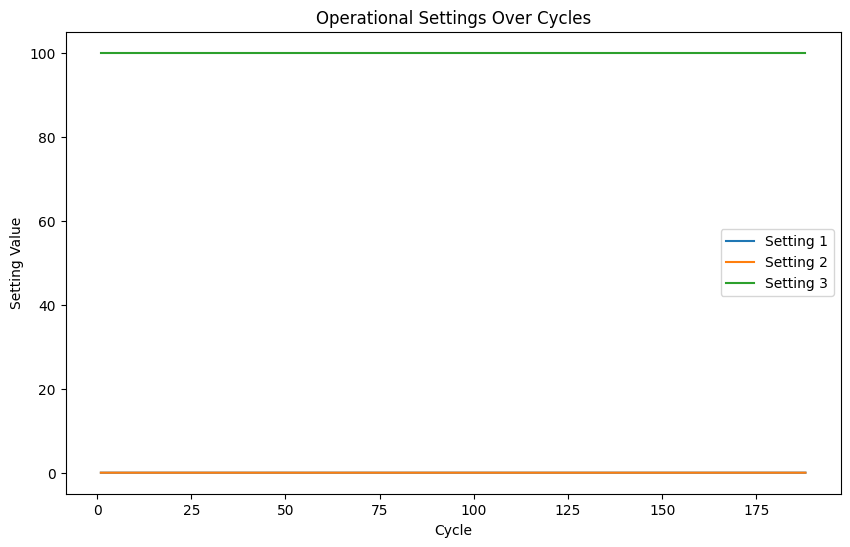

In [ ]:
engine_id = 6
engine_data = train_data[train_data['id'] == engine_id]

plt.figure(figsize=(10, 6))
plt.plot(engine_data['cycle'], engine_data['setting1'], label='Setting 1')
plt.plot(engine_data['cycle'], engine_data['setting2'], label='Setting 2')
plt.plot(engine_data['cycle'], engine_data['setting3'], label='Setting 3')
plt.xlabel('Cycle')
plt.ylabel('Setting Value')
plt.title('Operational Settings Over Cycles')
plt.legend()
plt.show()


## Heatmap
Correlaçao entre as diferentes features.


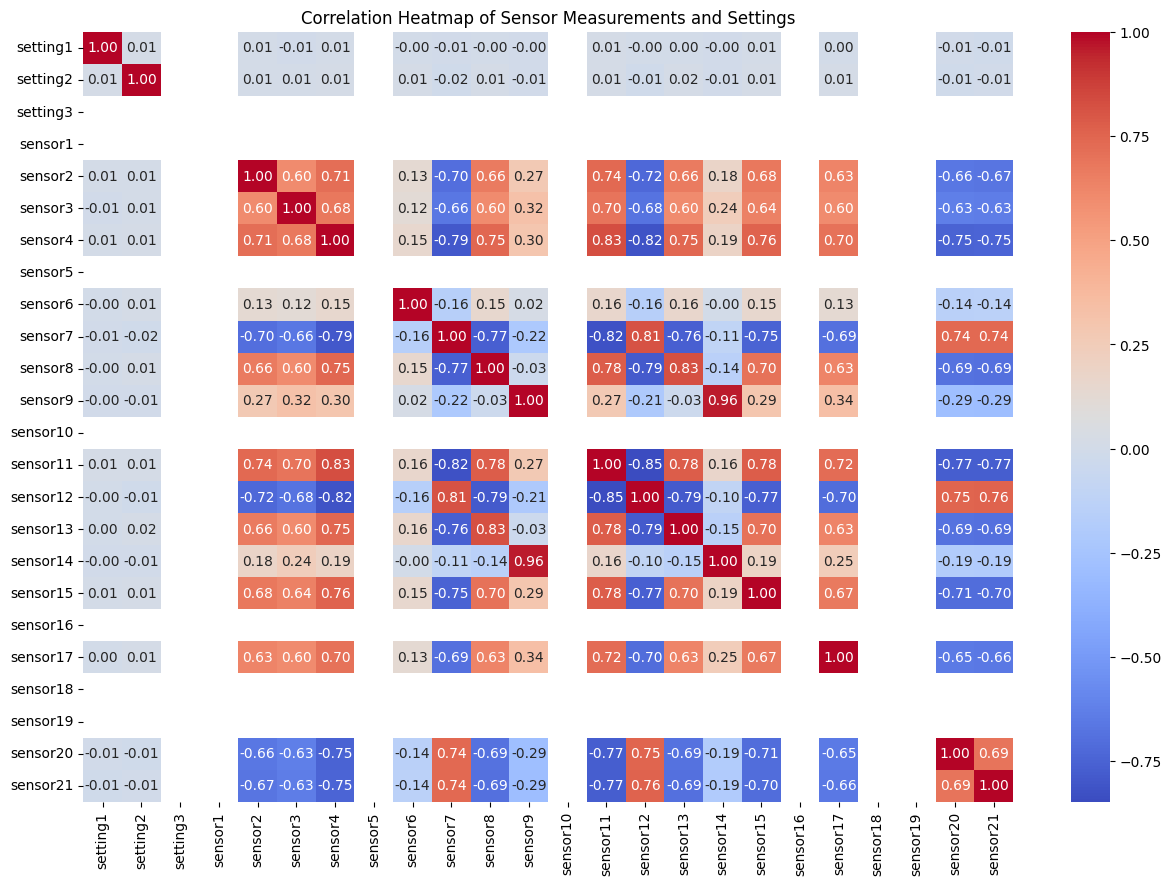

In [ ]:
plt.figure(figsize=(15, 10))
sns.heatmap(train_data.iloc[:, 2:].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Heatmap of Sensor Measurements and Settings')
plt.show()


## RUL Distribution
Quantos motores conseguiram atingir determinado valor de RUL.

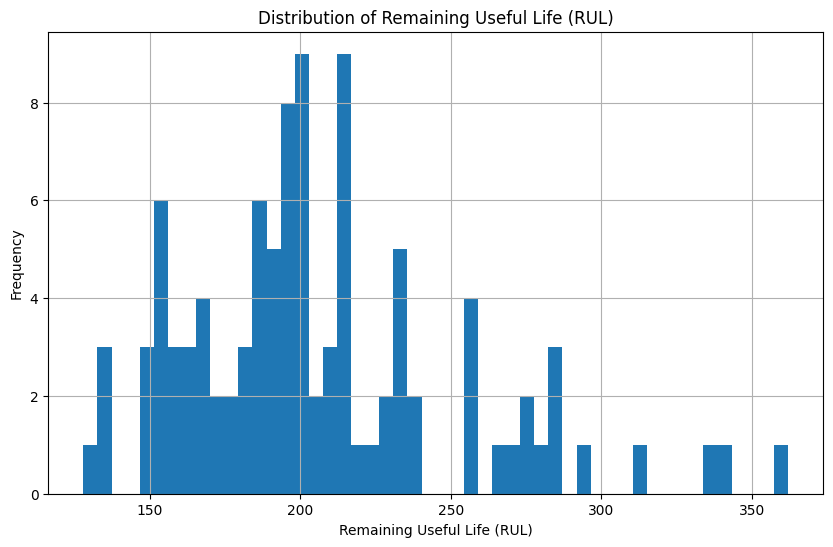

In [ ]:
# Calculate RUL for the training data
train_rul = train_data.groupby('id')['cycle'].max().reset_index()
train_rul.columns = ['id', 'max_cycle']
train_rul['RUL'] = train_rul['max_cycle']

plt.figure(figsize=(10, 6))
train_rul['RUL'].hist(bins=50)
plt.xlabel('Remaining Useful Life (RUL)')
plt.ylabel('Frequency')
plt.title('Distribution of Remaining Useful Life (RUL)')
plt.show()


# Data Preprocessing
Temos duas abordagens, ou usamos o RUL dataset ou calculamos nos mesmos.


## RUL calculation

In [74]:
max_cycles_train = train_data.groupby('id')['cycle'].max().reset_index()
max_cycles_train.columns = ['id', 'max_cycle']
train_data = train_data.merge(max_cycles_train, on='id')
train_data['RUL'] = train_data['max_cycle'] - train_data['cycle']
train_data.drop('max_cycle', axis=1, inplace=True)

In [37]:
print(test_data.columns)


Index(['id', 'cycle', 'setting1', 'setting2', 'setting3', 'sensor1', 'sensor2',
       'sensor3', 'sensor4', 'sensor5', 'sensor6', 'sensor7', 'sensor8',
       'sensor9', 'sensor10', 'sensor11', 'sensor12', 'sensor13', 'sensor14',
       'sensor15', 'sensor16', 'sensor17', 'sensor18', 'sensor19', 'sensor20',
       'sensor21', 'RUL', 'max_cycle'],
      dtype='object')


In [76]:
# Calculo do RUL (training data)

print("---------------------------- RUL DATA --------------------")
print(rul_data)


max_cycles_test = test_data.groupby('id')['cycle'].max().reset_index()
max_cycles_test.columns = ['id', 'max_cycle']
test_data = test_data.merge(max_cycles_test, on='id', how='left')
test_data['RUL'] = rul_data

print("---------------------------- TEST DATA --------------------")
print(test_data)


# Ensure 'RUL' column exists in both train and test data
assert 'RUL' in train_data.columns, "RUL column missing in training data"
assert 'RUL' in test_data.columns, "RUL column missing in test data"


---------------------------- RUL DATA --------------------
    RUL
0   112
1    98
2    69
3    82
4    91
..  ...
95  137
96   82
97   59
98  117
99   20

[100 rows x 1 columns]
---------------------------- TEST DATA --------------------
        id  cycle  setting1  setting2  setting3  sensor1  sensor2  sensor3  \
0        1      1    0.0023    0.0003     100.0   518.67   643.02  1585.29   
1        1      2   -0.0027   -0.0003     100.0   518.67   641.71  1588.45   
2        1      3    0.0003    0.0001     100.0   518.67   642.46  1586.94   
3        1      4    0.0042    0.0000     100.0   518.67   642.44  1584.12   
4        1      5    0.0014    0.0000     100.0   518.67   642.51  1587.19   
...    ...    ...       ...       ...       ...      ...      ...      ...   
13091  100    194    0.0049    0.0000     100.0   518.67   643.24  1599.45   
13092  100    195   -0.0011   -0.0001     100.0   518.67   643.22  1595.69   
13093  100    196   -0.0006   -0.0003     100.0   518.67   

## Normalização

In [15]:
# Select features to normalize
feature_cols = train_data.columns.difference(['id', 'cycle', 'RUL'])
scaler = MinMaxScaler()
train_data[feature_cols] = scaler.fit_transform(train_data[feature_cols])
test_data[feature_cols] = scaler.transform(test_data[feature_cols])


## LSTM application

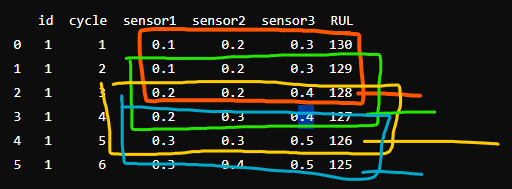

In [30]:
def create_sequences(data, seq_length=50):
    sequences = []
    labels = []
    ids = data['id'].unique()


    for id in ids:
        id_data = data[data['id'] == id].reset_index(drop=True)
        num_cycles = len(id_data)

        #print(id_data)
        # Debugging: Check the structure of id_data
        #print(f"ID: {id}, num_cycles: {num_cycles}, seq_length: {seq_length}")
        if num_cycles < seq_length:
            print(f"Skipping ID {id} because num_cycles < seq_length")
            continue

        for start in range(num_cycles - seq_length):


            seq = id_data.iloc[start:start+seq_length][feature_cols].values
            #if id == 1:
              #print(f"ID: {id} start value = {start}, range= {num_cycles - seq_length}, cycles = {num_cycles}")
              #print(seq)

            try:
                label = id_data.iloc[start+seq_length-1]['RUL']
            except KeyError as e:
                print(f"KeyError at ID {id}, start {start}: {e}")
                continue

            sequences.append(seq)
            labels.append(label)

    return np.array(sequences), np.array(labels)

# Create sequences for training and testing
seq_length = 50
X_train, y_train = create_sequences(train_data, seq_length)


print(f"NaNs in sequences: {np.isnan(X_train).sum()}")
print(f"NaNs in labels: {np.isnan(y_train).sum()}")


X_test, y_test = create_sequences(test_data, seq_length)
print(f"NaNs in sequences: {np.isnan(X_test).sum()}")
print(f"NaNs in labels: {np.isnan(y_test).sum()}")

NaNs in sequences: 0
NaNs in labels: 0
Skipping ID 1 because num_cycles < seq_length
Skipping ID 2 because num_cycles < seq_length
Skipping ID 14 because num_cycles < seq_length
Skipping ID 22 because num_cycles < seq_length
Skipping ID 25 because num_cycles < seq_length
Skipping ID 39 because num_cycles < seq_length
Skipping ID 85 because num_cycles < seq_length
NaNs in sequences: 0
NaNs in labels: 8162


In [17]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [18]:


# Build the LSTM model
model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(seq_length, len(feature_cols))),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.summary()

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_val, y_val))


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50, 100)           50000     
                                                                 
 dropout (Dropout)           (None, 50, 100)           0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                30200     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 80251 (313.48 KB)
Trainable params: 80251 (313.48 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
196/196

In [29]:


print(f"NaNs in y_test: {np.isnan(y_test).sum()}")
print(f"NaNs in y_pred: {np.isnan(y_pred).sum()}")

# Predictions
y_pred = model.predict(X_test)


# Calculate metrics
##rmse = np.sqrt(mean_squared_error(y_test, y_pred))
#mae = mean_absolute_error(y_test, y_pred)

#print(f'RMSE: {rmse}')
#print(f'MAE: {mae}')


NaNs in y_test: 8162
NaNs in y_pred: 0
256/256 [==============================] - 11s 42ms/step
NaNs in y_test: 8162
NaNs in y_pred: 0
